Spike trains are generated using univariate, self‐exciting Hawkes point process with an exponential kernel, using Ogata’s thinning algorithm. 

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf

from datetime import datetime

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from calculate_tau import func_single_exp_monkey, fit_single_exp
from calculate_acf import acf_sttc
from spike_train_utils import bin_spike_train_fixed_len
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
save_folder = project_folder_path + 'results\\synthetic_data\\dataset\\'
fig_folder = project_folder_path + 'results\\synthetic_data\\dataset\\'

In [3]:
def simulate_hawkes_thinning(rate_hz, tau_ms, alpha, duration_ms, seed=None):
    """
    Simulate 1D Hawkes with exponential kernel via Ogata's thinning.
    
    rate_hz    : stationary rate in spikes/sec
    tau_ms     : target time constant (ms)
    alpha      : kernel integral (<1 for stability)
    duration_ms: total sim time (ms)
    """
    rng = np.random.default_rng(seed)
    tau_kernel_ms = tau_ms * (1 - alpha)
    tau = tau_kernel_ms / 1000.0
    mu = rate_hz * (1 - alpha)       # baseline intensity (spikes/sec)
    
    t = 0.0
    events = []
    # current kernel sum K = sum_i (α/τ e^{-(t - t_i)/τ})
    K = 0.0
    
    # convert to seconds for intensity calculus
    T_sec = duration_ms / 1000.0
    
    while True:
        lambda_upper = mu + K             # global upper‐bound on intensity
        if lambda_upper <= 0:
            break
        # draw next candidate time increment (sec)
        w = rng.exponential(1.0 / lambda_upper)
        t += w
        if t >= T_sec:
            break
        # decay K over interval w
        K *= np.exp(-w/tau)
        # actual intensity at new t
        lambda_t = mu + K
        if rng.random() < lambda_t / lambda_upper:
            # accept
            events.append(t * 1000.0)  # store in ms
            # add kernel jump α/τ at event
            K += alpha / tau
    
    return np.array(events)

In [109]:
rate_hz     = 3.5     # target firing rate (Hz)
tau_ms      = 100.0    # desired autocorr time constant (ms)
alpha       = 0.3      # self‐excitation weight (must be <1)

duration_ms = 3000*1    # simulate for 10 min

# bin_size_ms = 50       # bin for ACF
# maxlag_ms   = 1000      # how far to compute ACF

In [110]:
# Generate 100 spike trains
num_trials = 100
all_spike_trains = []

for trial in range(num_trials):
    spikes = simulate_hawkes_thinning(
        rate_hz=rate_hz,
        tau_ms=tau_ms,
        alpha=alpha,
        duration_ms=duration_ms,
        seed=trial  # different seed per trial
    )
    all_spike_trains.append(spikes)

In [25]:
# obj_array = np.array(all_spike_trains, dtype=object)
# np.save(save_folder + 'spike_trains_tau100ms_fr3_5hz_1000.npy', obj_array, allow_pickle=True)

In [49]:
len(all_spike_trains)

100

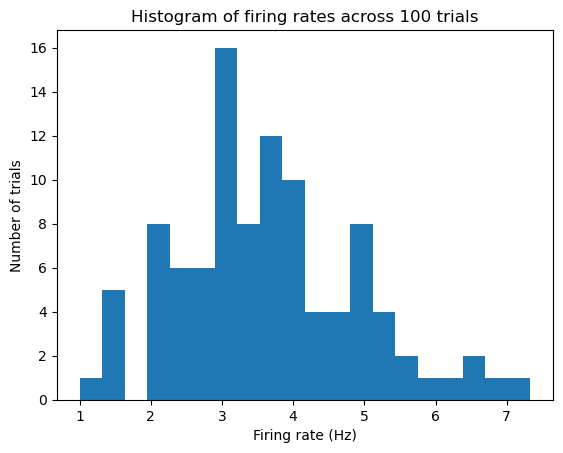

In [111]:
# Compute firing rates (Hz)
duration_s = duration_ms / 1000.0
rates = [len(train) / duration_s for train in all_spike_trains]

# Plot histogram
plt.figure()
plt.hist(rates, bins=20)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of trials')
plt.title('Histogram of firing rates across 100 trials')
plt.show()

In [112]:
fs = 1000
bin_size = 50 # in ms

all_spike_trains_binned_l = []
for i in range(len(all_spike_trains)):
    binned_spike_train = bin_spike_train_fixed_len([int(spike) for spike in all_spike_trains[i]],
                                                   bin_size, fs, duration_ms,
                                                   verbose_=False)
    all_spike_trains_binned_l.append(binned_spike_train)

In [89]:
len(all_spike_trains_binned_l)

100

In [113]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))
calc_acf_full = True

if calc_acf_full:
    acf_full_l = []
    
    for unit_idx, unit in enumerate(all_spike_trains_binned_l):
        if unit_idx % 50 == 0:
            print(f'Processing unit {unit_idx}')
        #spike_train_binned_int = np.asarray([int(spike) for spike in unit)
        spike_train_binned_acf = acf(unit, nlags=n_lags)
        acf_full_l.append(spike_train_binned_acf)
    
    acf_full_df = pd.DataFrame(np.array(acf_full_l), columns=acf_cols)
    
    print('NaNs in acf {}'.format(acf_full_df.isnull().any().any()))
    acf_full_df.head(3)
    
    # acf_full_df.to_pickle(dataset_folder + 'cut_30min\\binned\\acf\\acf_full_50ms_20lags_df.pkl')

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']
Processing unit 0
Processing unit 50
NaNs in acf False


In [ ]:
acf_full_df

In [114]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))
calc_isttc_full = True

bin_size = int(50 * (fs / 1000))
sttc_dt = int(25 * (fs / 1000))

if calc_isttc_full:
    acf_isttc_full_l = []
    
    for unit_idx, unit in enumerate(all_spike_trains):
        if unit_idx % 50 == 0:
            print(f'Processing unit {unit_idx}')
        spike_train_int = np.asarray([int(spike) for spike in unit])
        spike_train_acf = acf_sttc(spike_train_int, n_lags, bin_size, sttc_dt, duration_ms, verbose_=False)
        acf_isttc_full_l.append(spike_train_acf)
    
    acf_isttc_full_df = pd.DataFrame(np.array(acf_isttc_full_l), columns=acf_cols)
    
    print('NaNs in acf {}'.format(acf_isttc_full_df.isnull().any().any()))
    acf_isttc_full_df.head(3)

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']
Processing unit 0
Processing unit 50
NaNs in acf False


In [ ]:
acf_isttc_full_df

In [115]:
calc_taus = True

if calc_taus:
    acf_full_2d = acf_full_df[acf_cols].values
    print(f'acf_2d shape {acf_full_2d.shape}')
    acf_full_unit_ids = acf_full_df.index.values
    print(f'acf_full_unit_ids shape {acf_full_unit_ids.shape}')
    
    acf_full_dict = {}
    for unit_id_idx, unit_id in enumerate(acf_full_unit_ids):
        if unit_id_idx % 50 == 0:
            print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(acf_full_unit_ids)}, {datetime.now()}')
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(acf_full_2d[unit_id_idx,:],
                                                                                  start_idx_=1, exp_fun_=func_single_exp_monkey)
        taus = {'tau':tau,
                'tau_lower':tau_ci[0],
                'tau_upper':tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'explained_var': explained_var,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message}
        acf_full_dict[unit_id] = {'taus': taus,
                                  'acf': acf_full_2d[unit_id_idx,:]}

acf_2d shape (100, 21)
acf_full_unit_ids shape (100,)
#####
Processing unit 0, 1/100, 2025-05-07 11:32:45.460574
#####
Processing unit 50, 51/100, 2025-05-07 11:32:47.388531


In [116]:
if calc_taus:
    isttc_full_2d = acf_isttc_full_df[acf_cols].values
    print(f'isttc_full_2d shape {isttc_full_2d.shape}')
    isttc_full_unit_ids = acf_isttc_full_df.index.values
    print(f'isttc_full_unit_ids shape {isttc_full_unit_ids.shape}')
    
    isttc_full_dict = {}
    for unit_id_idx, unit_id in enumerate(isttc_full_unit_ids):
        if unit_id_idx % 50 == 0:
            print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(isttc_full_unit_ids)}, {datetime.now()}')
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(isttc_full_2d[unit_id_idx,:],
                                                                                  start_idx_=1, exp_fun_=func_single_exp_monkey)
        taus = {'tau':tau,
                'tau_lower':tau_ci[0],
                'tau_upper':tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'explained_var': explained_var,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message}
        isttc_full_dict[unit_id] = {'taus': taus,
                                    'acf': isttc_full_2d[unit_id_idx,:]}

isttc_full_2d shape (100, 21)
isttc_full_unit_ids shape (100,)
#####
Processing unit 0, 1/100, 2025-05-07 11:32:51.564116
#####
Processing unit 50, 51/100, 2025-05-07 11:32:52.519688


In [117]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [118]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50
#acf_full_plot_df = acf_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')

rows_with_nans_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

acf_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms
0,0,0.050310,-3.911275e+06,3.911275e+06,-4.859292e-09,True,acf_full,2.515495
1,1,0.494505,-2.946955e-01,1.283706e+00,5.798606e-01,True,acf_full,24.725269


In [119]:
acf_full_plot_df.describe()

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,tau_ms
count,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,49.500000,264.187442,-9.494789e+06,9.495318e+06,1.777495e-01,1.320937e+04
std,29.011492,2581.909771,4.734460e+07,4.734664e+07,2.388791e-01,1.290955e+05
min,0.000000,0.000250,-4.069313e+08,2.502496e-04,-4.859292e-09,1.251248e-02
25%,24.750000,0.077503,-1.794433e+03,1.662903e+00,3.675881e-04,3.875141e+00
50%,49.500000,0.113754,-6.151111e+00,1.028761e+01,4.066489e-02,5.687693e+00
75%,74.250000,1.804626,1.767328e-03,1.794622e+03,2.952111e-01,9.023130e+01
max,99.000000,25823.158163,1.865326e+00,4.069313e+08,9.306499e-01,1.291158e+06


In [120]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_isttc_full_plot_df = pd.DataFrame(data)
acf_isttc_full_plot_df['method'] = 'isttc_full'
acf_isttc_full_plot_df['tau_ms'] = acf_isttc_full_plot_df['tau'] * 50
#acf_isttc_full_plot_df = acf_isttc_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')

rows_with_nans_df = acf_isttc_full_plot_df[acf_isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

acf_isttc_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms
0,0,0.057805,-1.154133e+06,1.154133e+06,-9.535663e-10,True,isttc_full,2.890247
1,1,0.530912,-2.915357e-01,1.353359e+00,5.586027e-01,True,isttc_full,26.545577


In [121]:
acf_isttc_full_plot_df.describe()

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,tau_ms
count,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,49.500000,1909.941143,-6.886687e+07,6.887069e+07,1.549885e-01,9.549706e+04
std,29.011492,9688.357642,3.588069e+08,3.588248e+08,2.305444e-01,4.844179e+05
min,0.000000,0.001346,-3.092948e+09,1.346292e-03,-4.694391e-09,6.731461e-02
25%,24.750000,0.083803,-2.824070e+03,3.300469e+00,8.732442e-05,4.190133e+00
50%,49.500000,0.116034,-1.139284e+01,2.548054e+01,4.350918e-02,5.801687e+00
75%,74.250000,2.002841,-3.927081e-01,2.824252e+03,2.070114e-01,1.001420e+02
max,99.000000,68562.991113,2.435109e+00,3.093085e+09,9.629223e-01,3.428150e+06


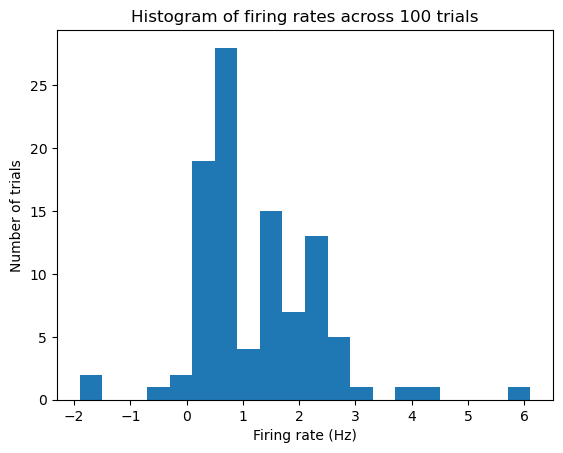

In [122]:
# Plot histogram
plt.figure()
plt.hist(np.log10(acf_full_plot_df['tau_ms'].values), bins=20)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of trials')
plt.title('Histogram of firing rates across 100 trials')
plt.show()

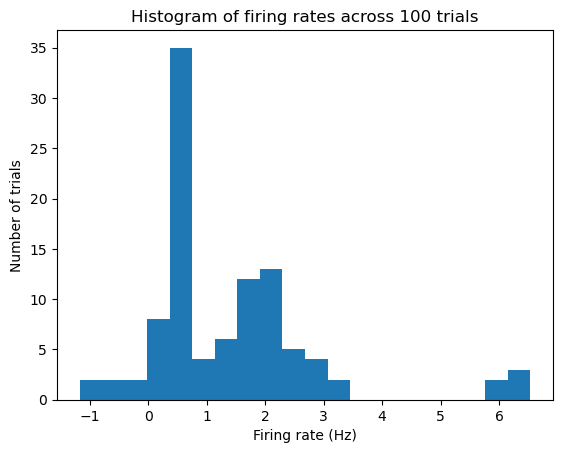

In [123]:
# Plot histogram
plt.figure()
plt.hist(np.log10(acf_isttc_full_plot_df['tau_ms'].values), bins=20)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of trials')
plt.title('Histogram of firing rates across 100 trials')
plt.show()

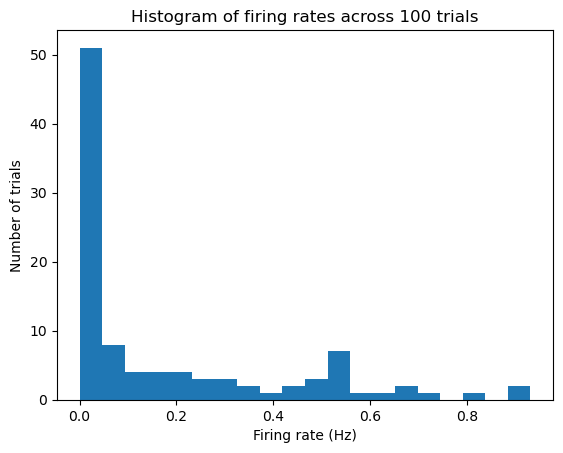

In [124]:
# Plot histogram
plt.figure()
plt.hist(acf_full_plot_df['fit_r_squared'].values, bins=20)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of trials')
plt.title('Histogram of firing rates across 100 trials')
plt.show()

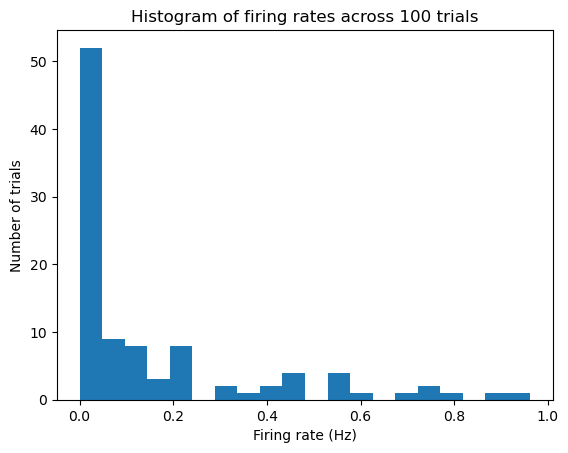

In [125]:
# Plot histogram
plt.figure()
plt.hist(acf_isttc_full_plot_df['fit_r_squared'].values, bins=20)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of trials')
plt.title('Histogram of firing rates across 100 trials')
plt.show()

51


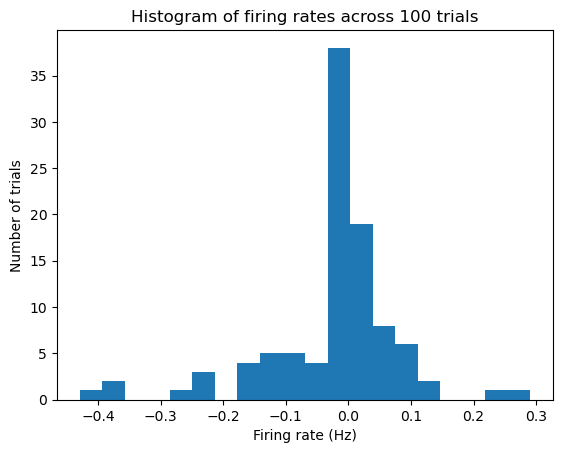

In [126]:
print(np.count_nonzero(acf_isttc_full_plot_df['fit_r_squared'].values-acf_full_plot_df['fit_r_squared'].values > 0))

plt.figure()
plt.hist(acf_isttc_full_plot_df['fit_r_squared'].values-acf_full_plot_df['fit_r_squared'].values, bins=20)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of trials')
plt.title('Histogram of firing rates across 100 trials')
plt.show()

#### Tests

In [ ]:
def bin_spikes(spikes_ms, bin_size_ms, duration_ms):
    bins = np.arange(0, duration_ms + bin_size_ms, bin_size_ms)
    counts, _ = np.histogram(spikes_ms, bins=bins)
    return counts

def autocorr(x, maxlag_bins):
    x = x - x.mean()
    full = np.correlate(x, x, mode='full')
    acf = full[full.size//2:] / full[full.size//2]
    return acf[:maxlag_bins]

def fit_exponential(acf, bin_size_ms):
    lags = np.arange(len(acf)) * bin_size_ms
    mask = lags >= bin_size_ms
    def exp_fn(t, A, τ): return A * np.exp(-t/τ)
    popt, _ = curve_fit(exp_fn, lags[mask], acf[mask], p0=(acf[1], 100.0))
    return popt  # (A, τ)


# 1) simulate Hawkes
spikes = simulate_hawkes_thinning(rate_hz, tau_ms, alpha, duration_ms)

# 2) bin & compute ACF
counts    = bin_spikes(spikes, bin_size_ms, duration_ms)
maxlag_bins = int(maxlag_ms / bin_size_ms)
acf       = autocorr(counts, maxlag_bins)

# 3) fit exponential (drop zero‐lag)
A_est, tau_est = fit_exponential(acf, bin_size_ms)
print(f"Fitted τ ≃ {tau_est:.1f} ms  (target {tau_ms} ms)")

# 4) plot
lags = np.arange(len(acf)) * bin_size_ms
plt.figure(figsize=(6,4))
plt.plot(lags, acf,    label='ACF')
plt.plot(lags, A_est*np.exp(-lags/tau_est),
         label=f'Fit: τ={tau_est:.1f} ms')
plt.xlabel('Lag (ms)')
plt.ylabel('Normalized ACF')
plt.title('Hawkes Spike Train ACF')
plt.legend()
plt.tight_layout()
plt.show()